# Machine Translation

In [10]:
!pip install portalocker # データセットを使用可能にする

In [11]:
# バージョン0.16ならうまくいったので
! pip install torchtext==0.16

In [12]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 58.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### データ準備

In [1]:
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.datasets import Multi30k # 機械翻訳用のデータセット
from torchtext.data.utils import get_tokenizer # token 作成
from torchtext.vocab import build_vocab_from_iterator # 辞書作成

In [2]:
# データのロード
data = Multi30k(split='train', language_pair=('de', 'en')) # dataを返すジェネレーター
data = list(data)

In [3]:
# データの分割
train_data, remaining = train_test_split(data, train_size=0.1, random_state=0)
_, val_data = train_test_split(remaining, test_size=0.2, random_state=0)

In [4]:
print(len(train_data), len(val_data))

2900 5221


In [5]:
# tokenizer
# tokenizerは一つのオブジェクトにするのが良い
token_transform = {}

# enやdeもよく使う文字列となるので変数にする
# 大文字で定義する変数 -> コンスタンツ　: 定義した後に変更されない(pythonでは出来ないが読み手に伝えることは出来る)
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# tokenizerのオブジェクト化
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    token_transform[ln] = get_tokenizer('spacy', language=ln)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [6]:
token_transform[SRC_LANGUAGE]('ich lerne Deutsch')

['ich', 'lerne', 'Deutsch']

In [7]:
token_transform[TGT_LANGUAGE]('I have a pen')

['I', 'have', 'a', 'pen']

### 辞書作成

In [8]:

def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE : 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

specials=['<unk>', '<pad>', '<bos>', '<eos>']
# これも一つのオブジェクトにまとめる
vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(data, ln), specials=specials)
    # 今回は全ての単語で辞書を作っているのでunknownはない想定
    vocab_transform[ln].set_default_index(vocab_transform[ln]['<unk>'])


In [9]:
vocab_transform['en']['cat']

813

In [10]:
# ### tokenizerの定義と辞書作成を一つに

# def yield_tokens(data_iter, language):
#     language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE : 1}
#     for data_sample in data_iter:
#         yield token_transform[language](data_sample[language_index[language]])

# token_transform = {}
# vocab_transform = {}
# SRC_LANGUAGE = 'de'
# TGT_LANGUAGE = 'en'
# specials=['<unk>', '<pad>', '<bos>', 'eos']


# # tokenizer、辞書のオブジェクト化
# for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
#     token_transform[ln] = get_tokenizer('spacy', language=ln)
#     vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(data, ln), specials=specials)
#     vocab_transform[ln].set_default_index(vocab_transform[ln]['<unk>'])


### 符号化の課程

In [11]:
# 1. token化
print(token_transform[TGT_LANGUAGE](train_data[0][1]))
# 2. 符号化
print([vocab_transform[TGT_LANGUAGE][token] for token in token_transform[TGT_LANGUAGE](train_data[0][1])])
# 3. tensor化
print(torch.tensor([vocab_transform[TGT_LANGUAGE][token] for token in token_transform[TGT_LANGUAGE](train_data[0][1])]))

['Two', 'people', 'are', 'walking', 'on', 'a', 'striped', 'path', '.']
[19, 22, 17, 42, 9, 4, 198, 297, 5]
tensor([ 19,  22,  17,  42,   9,   4, 198, 297,   5])


In [12]:
def data_preprocess(data_iter):
    data = []
    for (src, tgt) in data_iter:
        src_tensor = torch.tensor([vocab_transform[SRC_LANGUAGE][token] for token in token_transform[SRC_LANGUAGE](src)])
        tgt_tensor = torch.tensor([vocab_transform[TGT_LANGUAGE][token] for token in token_transform[TGT_LANGUAGE](tgt)])
        data.append((src_tensor, tgt_tensor))
    return data


In [13]:
train_data_tensor = data_preprocess(train_data)
val_data_tensor = data_preprocess(val_data)

In [14]:
train_data_tensor[0:3]

[(tensor([ 21,  42,  77,  11,   6, 259, 237,   4]),
  tensor([ 19,  22,  17,  42,   9,   4, 198, 297,   5])),
 (tensor([   5,   12,   70,   11,   13, 3256,   15,  428,   10,   26,  189,    4]),
  tensor([   6,   12,    9,    4, 1347, 1226,  173,    4,  267,  328,    5])),
 (tensor([    5,    12,    10,  2012,    70, 13529]),
  tensor([   6,   12,  581, 1066,   14,   27,  570,  359,    9,    5]))]

### padding、DataLoader作成

In [15]:
def collate_fn(batch):
    src_batch = []
    tgt_batch = []
    for src, tgt in batch:

        src_batch.append(torch.cat([torch.tensor([vocab_transform[SRC_LANGUAGE]["<bos>"]]),
                                    src,
                                    torch.tensor([vocab_transform[SRC_LANGUAGE]["<eos>"]])], dim=0))

        tgt_batch.append(torch.cat([torch.tensor([vocab_transform[TGT_LANGUAGE]["<bos>"]]),
                                    tgt,
                                    torch.tensor([vocab_transform[TGT_LANGUAGE]["<eos>"]])], dim=0))

    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=vocab_transform[SRC_LANGUAGE]['<pad>']) # vocab_transform['de']['<pad>'] : 1

    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=vocab_transform[TGT_LANGUAGE]['<pad>']) # vocab_transform['en']['<pad>'] : 1
    return src_batch, tgt_batch

train_loader = DataLoader(train_data_tensor, batch_size=16, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_data_tensor, batch_size=16, collate_fn=collate_fn, shuffle=False)


In [16]:
src, tgt = next(iter(train_loader))
print(src.shape)
print(tgt.shape)

torch.Size([16, 20])
torch.Size([16, 21])


In [17]:
torch.tensor([vocab_transform[SRC_LANGUAGE]["<eos>"]])

tensor([3])

In [18]:
torch.tensor([vocab_transform[TGT_LANGUAGE]["<bos>"]])

tensor([2])

### モデル構築

In [19]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=None, num_layers=1, rnn_type='LSTM', bidirectional=False):
        super().__init__()
        self.num_directional = 2 if bidirectional else 1

        # emdedding layer
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        input_size = embedding_dim

        # rnn typeを選択する処理
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError('Unsupported RNN type. Choose from ["LSTM", "RNN", "GRU"]')

        self.fc = nn.Linear(hidden_size*self.num_directional, output_size)

In [20]:
# encoderとdecoder作成
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super().__init__(vocab_size, embedding_dim, hidden_size, hidden_size, num_layers=num_layers, rnn_type='LSTM', bidirectional=False)

    def forward(self, src):
        embedded = self.embedding(src)
        output_seq, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


In [21]:
# decoder

class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1):

        """
        vocab_size : ターゲット(今回では英語のvocab_size)
        embedding_dim : vocab_sizeを何次元に圧縮するか
        hidden_size : 隠れ層の次元
        num_layers : Deep RNN に対応 多くて3くらい デフォルトで1

        bidirectionalはFalseにする(decoderでは使えない)
        """
        super().__init__(vocab_size, embedding_dim, hidden_size, vocab_size, num_layers=num_layers, rnn_type='LSTM', bidirectional=False)
        self.output_size = vocab_size

    def forward(self, input, hidden, cell):

        """
        input :  前の層の予測 [batch_size,] インデックスになっている
        hidden : 前の層の隠れ状態
        cell : 前の層のcellの状態
        順伝播を行う。1文字を処理をしてある文字がどの文字なのかを予測するlogitsの値が入っているoutputsを返す。
        vocab_sizeクラスの分類といえる?
        """
        input = input.unsqueeze(1) # [batch_size,] => [batch_size, 1]
        embedded = self.embedding(input)  # embedded : [batch_size, 1, embedding_dim]
        output_seq, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # output_seq : [batch_size, 1, hidden_size]
        # hidden : [num_layers * 1, batch_size, hidden_size]
        # cell : [num_layers * 1, batch_size, hidden_size]

        prediction = self.fc(output_seq.squeeze(1)) # prediction : [batch_size, vocab_size]

        return prediction, hidden, cell



In [22]:
# seq2seq

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):

        """
        encoder : エンコーダ
        decoder : デコーダー
        """
        super().__init__()
        self.device = device
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing=0.5):
        """
        src : [batch_size, vocab_size]
        tgt : [batch_size, ]
        teacher_forcing : teacher forcingをする閾値を確率で設定する　大きい程teacher forcingしやすい
        """
        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size

        # encoderのforward
        hidden, cell = self.encoder(src)


        # decoderのforward
        outputs = torch.zeros((batch_size, tgt_len, tgt_vocab_size)).to(self.device)
        input = tgt[:, 0] # <bos>
        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output : [batch_size, vocab_size]
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing
            top1 = output.argmax(1) # greedy sarch
            input = tgt[:, t] if teacher_force else top1

        return outputs

### 学習ループ

In [23]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs,  model_save_path=None):

    # ログ
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')


    # deviceの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        total_correct = 0

        # training
        for i, (src, tgt) in tqdm(enumerate(train_loader), desc='now training', total=len(train_loader), leave=False):
            src = src.to(device)
            # import pdb; pdb.set_trace()
            tgt = tgt.to(device)
            optimizer.zero_grad()

            outputs = model(src, tgt) # [batch_size, tgt_len, tgt_vocab_en]
            output_size = outputs.shape[-1]

            outputs = outputs[:,1:].reshape(-1, output_size)# [batch_size * tgtq_len, tgt_vocab_en] outputs[:,0]は<bos>なので無視
            tgt = tgt[:,1:].reshape(-1) # [batch_size, src_seq_len] -> [batch_size * src_seq_len]
            loss = criterion(outputs, tgt)
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
        train_losses.append(running_loss / len(train_loader))

        # validation
        # 評価用

        total_num = 0
        total_correct = 0

        for i, (src, tgt) in tqdm(enumerate(val_loader), desc='valdation', total=len(val_loader), leave=False):

            model.eval()
            with torch.no_grad():

                src = src.to(device)
                tgt = tgt.to(device)
                outputs = model(src, tgt, teacher_forcing=0) # [batch_size, seq_len, tgt_vocab_len], teacher_forcingなし

                tgt = tgt[:,1:].reshape(-1) # [batch_size, src_seq_len] -> [batch_size * src_seq_len]

                output_size = outputs.shape[-1]

                outputs = outputs[:,1:].reshape(-1, output_size) # [batch_size * seq_len, tgt_vocab_en]

                loss = criterion(outputs, tgt)
                running_val_loss += loss.item()



        val_losses.append(running_val_loss / len(val_loader))




        print(f"epoch={epoch}  train_losse={train_losses[-1]:.4f} val_loss={val_losses[-1]:.4f}")


        # モデル保存
        if best_val_loss > val_losses[-1]:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), f'{model_save_path}/seq2seq_{epoch}' )
            print(f'Model saved with validation loss: {best_val_loss:.4f}')


    return train_losses, val_losses

In [24]:
# deviceの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# vocab size
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])

embedding_dim = 300
hidden_size = 512
num_layers = 2

num_epochs = 20



# encoder,decoder
enc = Encoder(src_vocab_size, embedding_dim, hidden_size=hidden_size, num_layers=num_layers)
dec = Decoder(tgt_vocab_size ,embedding_dim, hidden_size, num_layers)

# seq2seq
model = Seq2Seq(enc, dec, device)

# 損失関数とoptimizer
learning_rate = 0.001
opt = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_transform[TGT_LANGUAGE]['<pad>'])

In [25]:
# colabの準備
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)
import sys
now_path = drive_path + "/MyDrive/深層学習/RNN"
sys.path.append(now_path)

model_save_path = f'{now_path}/machine_translation_models'

Mounted at /content/drive


In [26]:
train_losses, val_losses = train(model, train_loader, val_loader, opt, criterion, num_epochs, model_save_path = model_save_path)

epoch=0  train_losse=5.4504 val_loss=5.1271
Model saved with validation loss: 5.1271


epoch=1  train_losse=4.7562 val_loss=5.1479


epoch=2  train_losse=4.5140 val_loss=5.0668
Model saved with validation loss: 5.0668


epoch=3  train_losse=4.3028 val_loss=4.9975
Model saved with validation loss: 4.9975


epoch=4  train_losse=4.1192 val_loss=5.0219


epoch=5  train_losse=3.9588 val_loss=4.9471
Model saved with validation loss: 4.9471


epoch=6  train_losse=3.8082 val_loss=4.9037
Model saved with validation loss: 4.9037


epoch=7  train_losse=3.6644 val_loss=4.9100


epoch=8  train_losse=3.5135 val_loss=4.9568


epoch=9  train_losse=3.3865 val_loss=4.9345


epoch=10  train_losse=3.2505 val_loss=4.9369


epoch=11  train_losse=3.1026 val_loss=5.0761


epoch=12  train_losse=2.9572 val_loss=5.1114


epoch=13  train_losse=2.8143 val_loss=5.1646


epoch=14  train_losse=2.6762 val_loss=5.2087


epoch=15  train_losse=2.5094 val_loss=5.2792


epoch=16  train_losse=2.3464 val_loss=5.3741


epoch=17  train_losse=2.1700 val_loss=5.4845


epoch=18  train_losse=2.0154 val_loss=5.6069


epoch=19  train_losse=1.8239 val_loss=5.6380


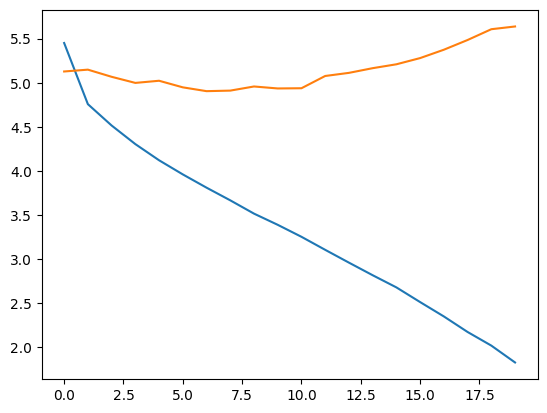

In [27]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### 推論コードを作る

In [28]:
enc = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers)
dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size, num_layers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).to(device)

In [29]:
model.load_state_dict(torch.load(f'{model_save_path}/seq2seq_7', map_location=torch.device(device)))

<All keys matched successfully>

In [30]:
def translate_sentence(model, sentence, device, max_len=50):
    max_len = max_len

    sentence = sentence
    # 1. tokenize
    tokenized_sentence = token_transform[SRC_LANGUAGE](sentence)
    # 2. 符号
    numericalaized = [vocab_transform[SRC_LANGUAGE]['<bos>']]  \
                    + [vocab_transform[SRC_LANGUAGE][token] for token in tokenized_sentence] \
                    + [vocab_transform[SRC_LANGUAGE]['<eos>']]
    # 3. Tnsor化
    numericalaized = torch.LongTensor(numericalaized).unsqueeze(0).to(device)

    # encoderのforward
    hidden, cell = model.encoder(numericalaized)

    # decoderへの最初の入力
    input = torch.LongTensor([vocab_transform[TGT_LANGUAGE]['<bos>']]).to(device)

    # Decoderのforwardで文章生成
    translated_sentence = []
    for _ in range(max_len):
        output, hidden, cell = model.decoder(input, hidden, cell)
        best_gess_index = output.argmax(1).item()
        best_word = vocab_transform[TGT_LANGUAGE].lookup_token(best_gess_index)
        translated_sentence.append(best_word)
        if best_gess_index == vocab_transform[TGT_LANGUAGE]['<eos>']:
            break
        input = torch.LongTensor([best_gess_index]).to(device)
    # ' '.join() はPythonの文字列メソッドで、リストやタプルに含まれる要素を一つの文字列として結合する際に使う
    return ' '.join(translated_sentence)

In [31]:
# A boat with several men on it is being pulled to the shore by a large team of horses.
sentence = "Ein Boot mit mehreren Männern darauf wird von einem großen Pferdegespann ans Ufer gezogen."
translated_sentence = translate_sentence(model, sentence, device, 50)
translated_sentence

'A couple is a a a a while a a to a . <eos>'

### ' '.join([要素が文字列のリスト])

In [32]:
words = ['I', 'love', 'PyTorch']
sentence = ' 　　　　'.join(words)
print(sentence)

I 　　　　love 　　　　PyTorch


### Beam_sarch

In [33]:
def translate_sentence_beam_search(model, sentence, device, max_len=50, k=10, alpha=0.7):

    # 1. tokenize
    tokenized = token_transform[SRC_LANGUAGE](sentence)

    # 2. 符号化,<bos>,<eos>を付ける
    numericalized = [vocab_transform[SRC_LANGUAGE]['<bos>']] \
                + [vocab_transform[SRC_LANGUAGE][token] for token in tokenized] + \
                  [vocab_transform[SRC_LANGUAGE]['<eos>']]
    # Tnsor化
    numericalized = torch.LongTensor(numericalized).unsqueeze(0).to(device) #[1, tgt_len] -> [tgt_len]

    # Encoderのforward
    hidden, cell = model.encoder(numericalized)

    # <bos> (最初のDecoderへの入力)]
    input = torch.LongTensor([vocab_transform[SRC_LANGUAGE]['<bos>']]).to(device)


    translated_sentence = []
    beam = [(0, [vocab_transform[TGT_LANGUAGE]['<bos>']], hidden, cell)]
    beam_log = []

    for _ in range(max_len):

        all_candidates = []
        for score, word_list, hidden, cell in beam: # 最初は1回、次は10回
            if word_list[-1] == vocab_transform[TGT_LANGUAGE]['<eos>']:
                all_candidates.append((score, word_list, hidden, cell))
            else:
                output, hidden, cell = model.decoder(input, hidden, cell)
                # output: [1, vocab_size]
                probs = torch.log_softmax(output, dim=-1)
                probs = probs.view(-1)

            for i, prob in enumerate(probs): # tgt_vocab分
                next_score = ((score * len(word_list)**alpha) + prob.item()) / ((len(word_list)+1)**alpha)
                # (score, wordlist, hidden, cell)
                all_candidates.append((next_score, word_list + [i], hidden, cell)) # [(0,[3,4,2,4...],[[[]]], [[[]]]), (0,[53,24,21,41...],[[[]]], [[[]]]), (0,[983,42,297,214...],[[[]]], [[[]]]) ]
        all_candidates.sort(key=lambda x : x[0], reverse=True) # score基準に並べ替え
        beam = all_candidates[:k]

        # log用
        beam_log.append(cand[0] for cand in all_candidates[:k])
    return beam, beam_log


In [35]:
# A boat with several men on it is being pulled to the shore by a large team of horses.
sentence = "Ein Boot mit mehreren Männern darauf wird von einem großen Pferdegespann ans Ufer gezogen."
beam, beam_log = translate_sentence_beam_search(model, sentence, device)

In [36]:
for b in beam:
    word_list = b[1]
    translated_sentence = [vocab_transform[TGT_LANGUAGE].lookup_token(word_id) for word_id in word_list]
    print(translated_sentence)

['<bos>', 'A', 'Asian', 'and', 'and', 'and', 'and', 'and', 'at', 'at', 'at', 'to', 'to', 'in', 'at', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['<bos>', 'A', 'Asian', 'and', 'and', 'and', 'and', 'and', 'at', 'at', 'at', 'to', 'to', 'to', 'at', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['<bos>', 'A', 'Asian', 'and', 'and', 'and', 'and', 'and', 'at', 'at', 'at', 'to', 'to', 'at', 'at', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['<bos>', 'A', 'Asian', 'and', 'and', 'and', 'and', 'and', 'at', 'at', 'at', 'to', 'to', 'in', 'in', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '